## Building Recommendation Functions

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- Building Recommendation Functions (this notebook)

**In this notebook, you'll find:**
- Classification functions using content-based filtering
- Brief summaries for each function

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics.pairwise import cosine_similarity

---
#### **Importing All-Feature Dataframe**

This is the aggregated dataframe of all of our datasets.

In [2]:
agg_df = pd.read_csv('../datasets/cleaned_data/all_features.csv')

agg_df.head()

,place,state,price,auto_accss_idx,pct_no_vehicle,pct_one_or_more_vehicles,transit_accss_idx,walkability_idx,cost_of_living,grocery_cost_idx,...,nov_avg_rain,dec_avg_rain,winter_avg_temp,spring_avg_temp,summer_avg_temp,autumn_avg_temp,winter_avg_rain,spring_avg_rain,summer_avg_rain,autumn_avg_rain
0,Asheville,NC,191.671287,0.580614,0.053756,0.946244,0.149850,9.382035,105.7,103.1,...,3.11,3.69,40.166667,53.333333,70.200000,55.333333,3.710000,4.160000,4.713333,3.423333
1,Austin,TX,280.389031,0.718323,0.059187,0.940813,0.286952,11.516379,129.4,96.7,...,2.52,2.42,53.400000,67.433333,82.333333,70.366667,2.243333,3.256667,2.386667,3.026667
2,Boston,MA,246.906229,0.759096,0.301252,0.698748,0.409262,14.936791,153.4,111.4,...,4.04,4.01,33.100000,49.700000,72.233333,56.000000,3.810000,3.790000,3.463333,3.703333
3,Cambridge,MA,246.035242,0.563985,0.102769,0.897231,0.160956,12.458517,173.7,115.5,...,4.00,3.85,31.100000,49.166667,71.633333,54.533333,3.570000,3.706667,3.523333,3.676667
4,Chicago,IL,235.391606,0.636256,0.169022,0.830978,0.310866,13.635529,107.4,97.2,...,2.44,2.04,28.133333,50.833333,73.933333,55.766667,1.760000,3.223333,3.643333,2.853333


In [3]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   place                     33 non-null     object 
 1   state                     33 non-null     object 
 2   price                     33 non-null     float64
 3   auto_accss_idx            33 non-null     float64
 4   pct_no_vehicle            33 non-null     float64
 5   pct_one_or_more_vehicles  33 non-null     float64
 6   transit_accss_idx         33 non-null     float64
 7   walkability_idx           33 non-null     float64
 8   cost_of_living            33 non-null     float64
 9   grocery_cost_idx          33 non-null     float64
 10  transportation_cost_idx   33 non-null     float64
 11  miscellaneous_cost_idx    33 non-null     float64
 12  population                33 non-null     int64  
 13  median_age                33 non-null     float64
 14  summer_comfo

In [4]:
agg_df['place'] = agg_df[['place', 'state']].apply(lambda x: ', '.join(x), axis=1)
agg_df.drop(columns='state', inplace=True)
agg_df.head()

,place,price,auto_accss_idx,pct_no_vehicle,pct_one_or_more_vehicles,transit_accss_idx,walkability_idx,cost_of_living,grocery_cost_idx,transportation_cost_idx,...,nov_avg_rain,dec_avg_rain,winter_avg_temp,spring_avg_temp,summer_avg_temp,autumn_avg_temp,winter_avg_rain,spring_avg_rain,summer_avg_rain,autumn_avg_rain
0,"Asheville, NC",191.671287,0.580614,0.053756,0.946244,0.149850,9.382035,105.7,103.1,82.8,...,3.11,3.69,40.166667,53.333333,70.200000,55.333333,3.710000,4.160000,4.713333,3.423333
1,"Austin, TX",280.389031,0.718323,0.059187,0.940813,0.286952,11.516379,129.4,96.7,109.9,...,2.52,2.42,53.400000,67.433333,82.333333,70.366667,2.243333,3.256667,2.386667,3.026667
2,"Boston, MA",246.906229,0.759096,0.301252,0.698748,0.409262,14.936791,153.4,111.4,131.8,...,4.04,4.01,33.100000,49.700000,72.233333,56.000000,3.810000,3.790000,3.463333,3.703333
3,"Cambridge, MA",246.035242,0.563985,0.102769,0.897231,0.160956,12.458517,173.7,115.5,95.7,...,4.00,3.85,31.100000,49.166667,71.633333,54.533333,3.570000,3.706667,3.523333,3.676667
4,"Chicago, IL",235.391606,0.636256,0.169022,0.830978,0.310866,13.635529,107.4,97.2,138.5,...,2.44,2.04,28.133333,50.833333,73.933333,55.766667,1.760000,3.223333,3.643333,2.853333


In [5]:
# Creating a dataframe with only the columns that include values we can request from the user
rec_model_df = agg_df[['place', 'winter_avg_temp', 'summer_avg_temp', 'chain_ratio', 'walkability_idx', 'political_left_lean', 'political_right_lean', 'miscellaneous_cost_idx', 'price']]

In [6]:
# Converting price column to monthly cost with Airbnb's estimated 30-day stay discount
rec_model_df['avg_monthly_price'] = (rec_model_df['price'] * 30) - ((rec_model_df['price'] * 30) * 0.25)
rec_model_df.drop(columns=['price'], inplace=True)
rec_model_df.head()

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_9997/1281049182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_model_df['avg_monthly_price'] = (rec_model_df['price'] * 30) - ((rec_model_df['price'] * 30) * 0.25)
/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_9997/1281049182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_model_df.drop(columns=['price'], inplace=True)


,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,0.3516,9.382035,0.597,0.386,111.2,4312.603960
1,"Austin, TX",53.400000,82.333333,0.3814,11.516379,0.714,0.264,105.9,6308.753191
2,"Boston, MA",33.100000,72.233333,0.2796,14.936791,0.806,0.175,157.9,5555.390144
3,"Cambridge, MA",31.100000,71.633333,0.3277,12.458517,0.715,0.263,176.7,5535.792952
4,"Chicago, IL",28.133333,73.933333,0.3717,13.635529,0.742,0.240,139.8,5296.311131


In [7]:
rec_model_df.to_csv('../streamlit/location_features_df.csv', index=False)

---
### **Building Functions to Recommend a Location Based on User Input**

#### **User Input Conversion**

This first function is meant to take in responses from a live user, as well as the dataframe to reference, and return the converted response list.

In [8]:
def wfh_input_converter(user_input_data, df):

    '''Inserting placeholder for location name'''
    user_input_data.insert(0, 'User Input')

    '''Converting user list to dictionary'''
    feat_keys = ['place', 'low_temp', 'high_temp', 'chain_pref', 'walk_pref', 'pol_dem_pref', 'misc_costs', 'monthly_budget']
    user_input_dict = dict(zip(feat_keys, user_input_data))

    '''Creating indices for ordinal input values'''
    # Chain preferences
    chain_mean = df['chain_ratio'].mean()
    chain_std = df['chain_ratio'].std()

    chain_input_options = ['I only eat at Mom-n-Pop restaurants', 'I prefer non-chain restaurants', 'I like a combination of both', 'I would rather go somewhere that has a drive-thru', 'The faster the food the better']
    chain_input_index = [chain_mean - (2*chain_std), chain_mean - (1*chain_std), chain_mean, chain_mean + (1*chain_std), chain_mean + (2*chain_std)]
    chain_mapper = dict(zip(chain_input_options, chain_input_index))
    
    # Walkability preferences
    walk_mean = df['walkability_idx'].mean()
    walk_std = df['walkability_idx'].std()

    walk_input_options = ['Not important at all', 'Not very important', 'Neutral', 'A little important', 'Very important']
    walk_input_index = [walk_mean - (2*walk_std), walk_mean - (1*walk_std), walk_mean, walk_mean + (1*walk_std), walk_mean + (2*walk_std)]
    walkability_mapper = dict(zip(walk_input_options, walk_input_index))

    # Political lean preferences
    # Using the mean here instead of 50/50 because most locations have a slight to moderate left lean, meaning that if we set the default value to 0.5, we'd be unintentionally biasing the results
    pol_mean = df['political_left_lean'].mean()
    pol_std = df['political_left_lean'].std()

    pol_pref_options = ['Strong left lean preferred', 'Moderate left lean preferred', 'Moderate right lean preferred', 'Strong right lean preferred']
    pol_pref_index = [pol_mean + (2*pol_std), pol_mean + (1*pol_std), pol_mean - (1*pol_std), pol_mean - (2*pol_std)]
    pol_pref_mapper = dict(zip(pol_pref_options, pol_pref_index))

    '''Mapping user-provided preferences to defined numerical value'''
    # Chain preferences
    for k, v in chain_mapper.items():
        if user_input_dict['chain_pref'] == k:
            user_input_dict['chain_pref'] = v

    # Walkability preferences
    for k, v in walkability_mapper.items():
        if user_input_dict['walk_pref'] == k:
            user_input_dict['walk_pref'] = v

    # Political lean preferences
    for k, v in pol_pref_mapper.items():
        if user_input_dict['pol_dem_pref'] == k:
            user_input_dict['pol_dem_pref'] = v
        else:
            user_input_dict['pol_dem_pref'] = pol_mean
    
    pol_rep_pref = 1 - user_input_dict['pol_dem_pref']

    '''Estimating miscellaneous cost index based on user input'''
    misc_mean = df['miscellaneous_cost_idx'].mean()
    misc_std = df['miscellaneous_cost_idx'].std()

    user_input_dict['misc_costs'] = misc_mean + (user_input_dict['misc_costs'] * misc_std/5)

    '''Converting dictionary values to list'''
    user_input_list = list(user_input_dict.values())

    '''Inserting the Repulican-lean political value into our user list'''
    user_input_list.insert(6, pol_rep_pref)

    '''Adding the updated list as a new row in our dataframe'''
    df.loc[len(df)] = user_input_list
    
    return user_input_list

Now that we have our user's data in the desired format, we'll need to create a function that will find the location with the closest cosine similarity to the user's given preferences.

#### **Cosine Similarity Recommendation**

In [9]:
def find_rec(df, input_row = 'User Input'): # Defining the input row here because we will always be evaluating/recommending for the 'User Input' row

    '''Scaling all numeric columns'''
    feature_cols = df.columns[1:]
    minmax = MinMaxScaler()
    scaled_df = minmax.fit_transform(df[feature_cols])

    '''Setting all place indices for reference'''
    indices = pd.Series(df.index, index=df['place'])
    user_index = indices[input_row]

    '''Finding the cosine similarities between all location vectors'''
    cosine_sim = cosine_similarity(scaled_df)

    '''Filtering and sorting the cosine similarity values for input data'''
    sim_scores = list(enumerate(cosine_sim[user_index]))
    sim_scores_sorted = sorted(sim_scores, key = lambda x:x[1], reverse=True)

    '''Finding and returning the location most similar to user's preferences'''
    best_fit_score = sim_scores_sorted[1]
    best_fit_index = best_fit_score[0]
    recommended_place = df['place'].iloc[best_fit_index]

    return f'You should go to: {recommended_place}!'

With our two functions built, we should now be able to pass in example user replies and have a location recommendation as our output.

The questions that the user will be asked are:
1. When would you plan on going?
2. How many people would you be staying with?
3. What is your ideal temperature range?
4. If you aren't eating at home, which of these best describes your meal preferences?
5. How important is walkability?
6. Do you care about the political lean of the city you would be living in?
7. Which of these are you likely to spend money on?
8. How much are you willing to spend on accomodations each month?

*Note: The first two questions are being used for the results page, but are not included in our recommendation system.*

In [10]:
ex_user_1 = [65, 75, 'I prefer non-chain restaurants', 'Neutral', 'Moderate left lean preferred', 5, 6000]

In [11]:
wfh_input_converter(ex_user_1, rec_model_df)

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_9997/470807313.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[len(df)] = user_input_list


['User Input',
 65,
 75,
 0.22781856884367266,
 12.07544654388207,
 0.7012,
 0.29879999999999995,
 154.74250341119108,
 6000]

In [12]:
find_rec(rec_model_df)

'You should go to: San Diego, CA!'

According to our function, the location with the nearest cosine vector degree is San Diego, CA. The next question that arises here is: what if the user wants more than one recommendation? 

I'm going to modify the function slightly to run in the same way but return more than one recommendation in the output.

#### **Cosine Similarity Multi-Location Recommendation**

In [13]:
def multi_place_recommender(df, input_row = 'User Input'): # Same input values

    '''Scaling all numeric columns'''
    feature_cols = df.columns[1:]
    minmax = MinMaxScaler()
    scaled_df = minmax.fit_transform(df[feature_cols])

    '''Setting all place indices for reference'''
    indices = pd.Series(df.index, index=df['place'])
    user_index = indices[input_row]

    '''Finding the cosine similarities between all location vectors'''
    cosine_sim = cosine_similarity(scaled_df)

    '''Filtering and sorting the cosine similarity values for input data'''
    sim_scores = list(enumerate(cosine_sim[user_index]))
    sim_scores_sorted = sorted(sim_scores, key = lambda x:x[1], reverse=True)

    '''Finding and returning the five locations most similar to user's preferences'''
    best_fit_scores = sim_scores_sorted[1:6]
    best_fit_indices = [i[0] for i in best_fit_scores]
    recommended_places = df['place'].iloc[best_fit_indices]

    print('Here are a few options you might enjoy:')
    return [i for i in recommended_places]

In [14]:
multi_place_recommender(rec_model_df)

Here are a few options you might enjoy:


['San Diego, CA',
 'Oahu, HI',
 'Los Angeles, CA',
 'New York City, NY',
 'Santa Clara, CA']

The above function is very similar to the prior recommender, so we can see here that the best fit (generated through cosine similarity) of San Diego, CA is the same as our previous recommendation. 

We can also see the next four closest fits to our user's input are:
- Oahu, HI
- Los Angeles, CA,
- New York City, NY 
- Santa Clara, CA

We can't verify our results in the traditional sense because we don't have a feature or any known values to test against, but one option is to look at the top recommended places to ensure some level of similarity. 

From the subset of our dataframe below, it does appear that these locations have features that are relatively close in value to one another, indicating that our function is not returning a list of random places that have little to no similarities.

In [15]:
rec_model_df.apply(lambda row: row[rec_model_df['place'].isin(['San Diego, CA', 'Oahu, HI', 'Los Angeles, CA', 'New York City, NY', 'Santa Clara, CA', 'User Input'])])

,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
14,"Los Angeles, CA",51.100000,76.866667,0.370800,13.572348,0.7100,0.2690,133.200000,6458.191982
18,"New York City, NY",37.260000,75.953333,0.238500,13.491196,0.7210,0.2680,137.900000,5258.831493
20,"Oahu, HI",73.500000,81.000000,0.274500,11.998872,0.6250,0.3570,124.000000,6089.645141
25,"San Diego, CA",52.900000,76.833333,0.363600,12.186630,0.6020,0.3750,152.900000,6894.999565
28,"Santa Clara, CA",48.433333,70.866667,0.390400,13.554884,0.7260,0.2520,158.400000,5079.235597
33,User Input,65.000000,75.000000,0.227819,12.075447,0.7012,0.2988,154.742503,6000.000000


The above functions work as desired and provide the output we were hoping for. 

However, pivoting to a more business-centric approach, we believe that if users are coming to our location recommendation website and entering the same preferences each time, they will always get the same result and, in turn, will likely use the program once and never return.

To address this, we'd like to answer the question of: what if the user wants a different recommendation each time they enter their preferences, even if they are entering the exact same information?

In theory, we could iterate through our top five list above and select one location out of these to recommend. We're going to use KMeans here, however, to add some variety and test out a different recommendation methodology.

#### **KMeans Random Cluster Recommendation**

In [16]:
# First, we'll select our dataframe to be scaled
X = rec_model_df.iloc[:, 1:]
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [17]:
# Now instantiating the KMeans model and fitting to our scaled df
km = KMeans(random_state=42)
km.fit(X_scaled)

# Making cluster predictions for each location and all adding to a dataframe
kmeans_cluster_df = pd.concat([pd.Series(rec_model_df['place']), pd.Series(km.predict(X_scaled))], axis=1)
kmeans_cluster_df.rename(columns={0:'cluster'}, inplace=True)
kmeans_cluster_df.head(7)

,place,cluster
0,"Asheville, NC",7
1,"Austin, TX",2
2,"Boston, MA",5
3,"Cambridge, MA",4
4,"Chicago, IL",4
5,"Columbus, OH",7
6,"Dallas, TX",2


After scaling the data, we're able generate cluster predictions for each location.

Putting all of the above together, below we'll create a function similar to the others but that will provide a recommended place that is randomly selected from a list of locations that fall in the same cluster as the user input row.

In [18]:
def kmeans_rec(df, k_val):
    # Setting X and scaling
    X = df.iloc[:, 1:]
    
    # We're using Standard Scaler here to, again, add variety and see if this affects our recommendations at all
    sc = StandardScaler() 
    X_scaled = sc.fit_transform(X)

    # Instantiating and fitting model
    km = KMeans(n_clusters=k_val, random_state=42)
    km.fit(X_scaled)

    # Predicting clusters for all locations
    cluster_preds = km.predict(X_scaled)

    # Creating df with place names and cluster preds
    kmeans_cluster_df = pd.concat([pd.Series(df['place']), pd.Series(cluster_preds)], axis=1)
    kmeans_cluster_df.rename(columns={0:'cluster'}, inplace=True)

    # Setting variable to reference User Input index value and cluster pred
    kmeans_input_index = kmeans_cluster_df[kmeans_cluster_df['place'] == 'User Input'].index[0]
    kmeans_user_cluster = kmeans_cluster_df.iloc[kmeans_input_index]['cluster']

    # Creating a list of locations that were in the same cluster as user input values
    same_cluster_list = list(kmeans_cluster_df[kmeans_cluster_df['cluster'] == kmeans_user_cluster]['place'])
    
    # Dropping 'User Input' from possible recommended locations
    same_cluster_list.remove('User Input')

    # Returning one randomly-selected location from same cluster list
    kmeans_final_rec = np.random.choice(same_cluster_list)

    return f'You should go to: {kmeans_final_rec}!'

We'll now test the above function on the same test user input row that we used for our other trials.

In [19]:
kmeans_rec(rec_model_df, 8)

'You should go to: San Diego, CA!'

In [20]:
kmeans_rec(rec_model_df, 8)

'You should go to: Oahu, HI!'

We can see that our KMeans function randomly selects a location to recommend when we run it with the same input. 

To help us visualize what's happening behind the scenes, below are the 8 different clusters that were created for our locations. 

In [21]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(kmeans_cluster_df.groupby('cluster')['place'].apply(list))

,place
cluster,
0,"[Jersey City, NJ, New Orleans, LA, New York City, NY, Newark, NJ]"
1,"[Hawaii, HI, Kauai, HI, Maui, HI]"
2,"[Austin, TX, Dallas, TX, Fort Lauderdale, FL, Las Vegas, NV, Nashville, TN, Rhode Island, RI]"
3,"[San Mateo, CA, Santa Cruz, CA]"
4,"[Cambridge, MA, Chicago, IL, Los Angeles, CA, Santa Clara, CA, Twin Cities, MN]"
5,"[Boston, MA, Denver, CO, Oakland, CA, Portland, OR, San Francisco, CA, Seattle, WA, Washington, DC]"
6,"[Oahu, HI, San Diego, CA, User Input]"
7,"[Asheville, NC, Columbus, OH, Fort Worth, TX, Salem, OR]"


We're going to take a look at our KMeans inertia and silhouette scores to help us evaluate our clustering performance.

In [22]:
print(f'KMeans Inertia: {km.inertia_}')
print(f'KMeans Silhouette Score: {silhouette_score(X_scaled, km.labels_)}')

KMeans Inertia: 69.77531825586827
KMeans Silhouette Score: 0.21538057854762774


Our inertia is high, meaning that our KMeans clusters are not grouping our locations together as well as they could be. The low silhouette score also tells us that our data points are only moderately similar to one another.

Let's plot these two to see if there is an optimal number of clusters that could potentially improve one or both scores.

In [23]:
inertia_list = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)

silhouette_list = []

for k in range(2,20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    silhouette_list.append(silhouette_score(X_scaled, kmeans.labels_))

print(f'Inertia list first vals: {inertia_list[:5]}')
print(f'Silhouette list first vals: {silhouette_list[:5]}')

Inertia list first vals: [272.0, 179.8300743201965, 130.7937350562018, 111.90220866775107, 96.19292633251732]
Silhouette list first vals: [0.28972838268934986, 0.32957623647687884, 0.24452218337444198, 0.21286938272467773, 0.20252176058948126]


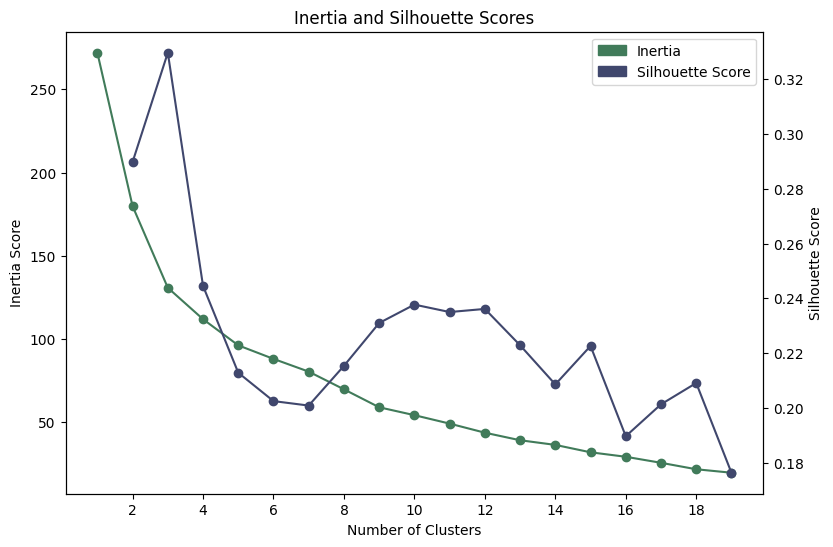

In [24]:
fig, ax = plt.subplots(figsize=(9, 6))

inertia = ax.plot(range(1,20), inertia_list, marker = 'o', color = '#417B5A')
ax.set(xlabel= 'Number of Clusters', xticks=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20], ylabel= 'Inertia Score', title='Inertia and Silhouette Scores')

ax2 = ax.twinx()
sil_score = ax2.plot(range(2, 20), silhouette_list, marker = 'o', color = '#40476D')
ax2.set(ylabel = 'Silhouette Score')

inert_idx = mpatches.Patch(color='#417B5A', label='Inertia')
sils_idx = mpatches.Patch(color='#40476D', label='Silhouette Score')
plt.legend(handles=[inert_idx, sils_idx], bbox_to_anchor=((1,1)))

plt.show();

From the plots above, our silhouette score looks to have quite a bit of fluctuation, while our inertia scores steadily decline (though the 'elbow' looks to occur around the 3-5 cluster range). 

Our original value of eight clusters is where we see a crossover, but depending on which metric we're trying to optimize for, our best k value would be three (for silhouette score) or 18 (for inertia). If we wanted to optimize for both, our best bet would likely be 4, 10, or 12 clusters.

We'll run our function again to see if we get different predictions when we change the value of k.

In [25]:
kmeans_rec(rec_model_df, 12)

'You should go to: Oahu, HI!'

In [26]:
# Re-instantiating to look at the new assigned cluster values
km = KMeans(n_clusters=12, random_state=42)
km.fit(X_scaled)

kmeans_cluster_df_2 = pd.concat([pd.Series(rec_model_df['place']), pd.Series(km.predict(X_scaled))], axis=1)
kmeans_cluster_df_2.rename(columns={0:'cluster'}, inplace=True)

pd.DataFrame(kmeans_cluster_df_2.groupby('cluster')['place'].apply(list))

,place
cluster,
0,"[Jersey City, NJ, New Orleans, LA, New York City, NY, Newark, NJ]"
1,"[Hawaii, HI, Kauai, HI, Maui, HI]"
2,"[Fort Worth, TX, Las Vegas, NV]"
3,"[Cambridge, MA, Chicago, IL, Santa Clara, CA, Twin Cities, MN]"
4,"[Asheville, NC, Salem, OR]"
5,"[Austin, TX, Fort Lauderdale, FL, Los Angeles, CA, Nashville, TN]"
6,"[Boston, MA, Denver, CO, Oakland, CA, Portland, OR, Seattle, WA, Washington, DC]"
7,"[San Mateo, CA, Santa Cruz, CA]"
8,"[Oahu, HI, User Input]"


In [27]:
print(f'KMeans Inertia (12 clusters): {km.inertia_}')
print(f'KMeans Silhouette Score (12 clusters): {silhouette_score(X_scaled, km.labels_)}')

KMeans Inertia (12 clusters): 43.71880325826092
KMeans Silhouette Score (12 clusters): 0.2361414016241995


Changing the k value to 12 brought down our inertia by about 37%, and also increased the silhouette score by ~0.02. The tracks with our new clusters shown above, as we can see a lot of the same groupings, with some locations swapped or moved into their own clusters.

The silhouette score seems like it will improve marginally, at best, so if we were going to move forward with the KMeans function, we would likely prioritize inertia as our metric and use either 10 or 12 clusters.

---
#### **Conclusion**

As noted above, we are unable to explicitly measure our functions' accuracy and/or efficacy as we do not have a defined target variable. The inertia and silhouette scores leave a lot of room for improvement.

That being said, our functions all work in the way they were meant to and return recommendations that do not appear to be wildly off-base. 

We also believe that San Diego, CA and Oahu, HI being in the KMeans cluster that was assigned to our example user does, in a sense, verify our first function's results. While we cannot  directly compare the means of measurement employed by KMeans clustering (which uses Euclidean distance to minimize inter-cluster variance) versus cosine similarity, we can, very broadly speaking, assign some level of credibility to the fact that these locations were also the top two seen in our first function.

We'll be using the original cosine method to make recommendations on the streamlit web app.

---
#### **Final Notes**
- From this notebook, we'll be exporting the slimmed dataset that was used in each of our functions (not including the 'User Input' row), as well as our two functions for data conversion and recommendation output.
- This is the final notebook in the series, but please see our [streamlit.py file](../streamlit/stlib/final_draft_app.py) to view the code for our web application.